In [1]:
from phi.torch.flow import *

bound = Box(x=(0, 32), y=(0, 40))
res = spatial(x=32, y=40)
inflow_loc = tensor([(12, 4), (13, 6), (14, 5), (16, 5)], batch('inflow_loc'), channel(vector="x,y"))

SMOKE_INIT = CenteredGrid(values=math.zeros(batch(inflow_loc=4)), boundary=extrapolation.ZERO_GRADIENT, bounds=bound,
                          resolution=res)
VELOCITY_INIT = StaggeredGrid(values=math.zeros(batch(inflow_loc=4)), boundary=extrapolation.ZERO,
                              bounds=bound, resolution=res)
INFLOW = (1. / 3.) * CenteredGrid(values=Sphere(center=inflow_loc, radius=3), boundary=extrapolation.ZERO_GRADIENT,
                                  bounds=bound, resolution=res)


@jit_compile
def step(in_smoke: CenteredGrid, in_velocity: StaggeredGrid, in_inflow: CenteredGrid, in_dt: float = 1,
         buoyancy_factor: float = 1):
    if SMOKE_INIT.shape.spatial.shape.size == 2:
        _buoyancy = (in_smoke * (0, buoyancy_factor)).at(in_velocity)
    elif SMOKE_INIT.shape.spatial.shape.size == 3:
        _buoyancy = (in_smoke * (0, 0, buoyancy_factor)).at(in_velocity)
    else:
        raise ValueError('Invalid spatial dimension')
    in_smoke = advect.mac_cormack(field=in_smoke, velocity=in_velocity, dt=in_dt) + in_inflow
    in_velocity = advect.semi_lagrangian(field=in_velocity, velocity=in_velocity, dt=in_dt) + _buoyancy
    in_velocity, _pressure = fluid.make_incompressible(velocity=in_velocity)
    return in_smoke, in_velocity

C:\Users\imeho\AppData\Roaming\Python\Python311\site-packages\phiml\backend\torch\_torch_backend.py:800: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


<Figure size 1200x500 with 8 Axes>

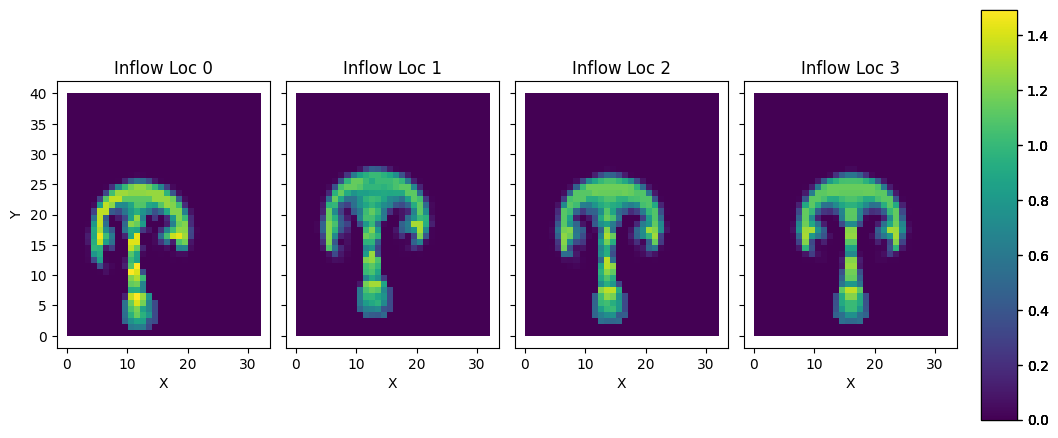

In [2]:
TEST_SMOKE = SMOKE_INIT
TEST_VELOCITY = VELOCITY_INIT

for _ in range(20):
    TEST_SMOKE, TEST_VELOCITY = step(in_smoke=TEST_SMOKE, in_velocity=TEST_VELOCITY, in_inflow=INFLOW, in_dt=1)

plot(TEST_SMOKE)

In [3]:
def simulate(in_smoke: CenteredGrid, in_velocity: StaggeredGrid, in_steps: int = 20):
    for _ in range(in_steps):
        in_smoke, in_velocity = step(in_smoke=in_smoke, in_velocity=in_velocity, in_inflow=INFLOW, in_dt=1)
    _loss = field.l2_loss(in_smoke - field.stop_gradient(in_smoke.inflow_loc[-1]))
    return _loss, in_smoke, in_velocity


f_sim_grad = field.functional_gradient(f=simulate, wrt='in_velocity', get_output=True)

LR = 1e-03

for epoch in range(80):
    (LOSS, SMOKE, VELOCITY), dVELOCITY = f_sim_grad(in_smoke=SMOKE_INIT, in_velocity=VELOCITY_INIT)
    VELOCITY_INIT = VELOCITY_INIT - LR * dVELOCITY
    if epoch < 3 or epoch % 10 == 9:
        print(f'Epoch: {epoch}, Loss: {np.sum(LOSS.numpy())}')

Epoch: 0, Loss: 262.3074951171875
Epoch: 1, Loss: 259.578125
Epoch: 2, Loss: 251.14077758789062
Epoch: 9, Loss: 217.06332397460938
Epoch: 19, Loss: 193.2369384765625
Epoch: 29, Loss: 185.82276916503906
Epoch: 39, Loss: 179.80020141601562
Epoch: 49, Loss: 168.8152618408203
Epoch: 59, Loss: 161.16905212402344
Epoch: 69, Loss: 157.23678588867188
Epoch: 79, Loss: 154.8978271484375


<Figure size 1200x500 with 4 Axes>

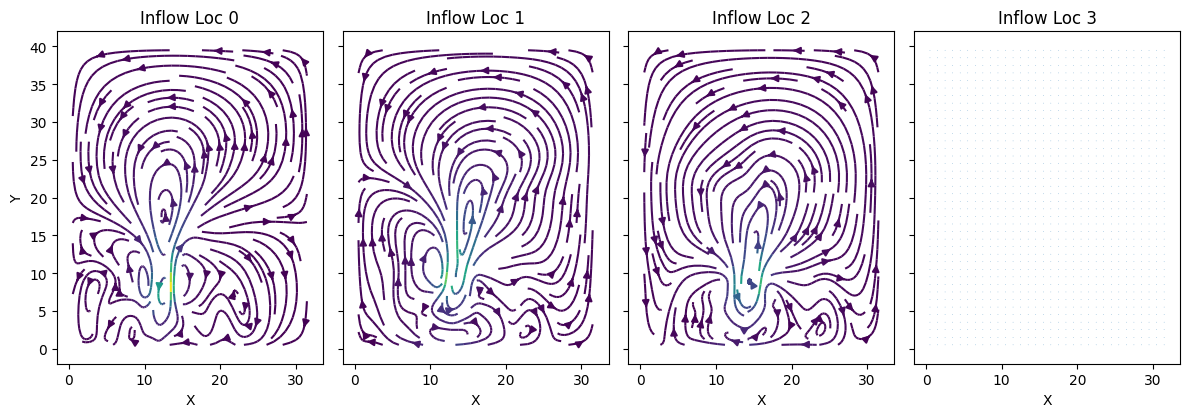

In [4]:
plot(VELOCITY_INIT)

<Figure size 1200x500 with 8 Axes>

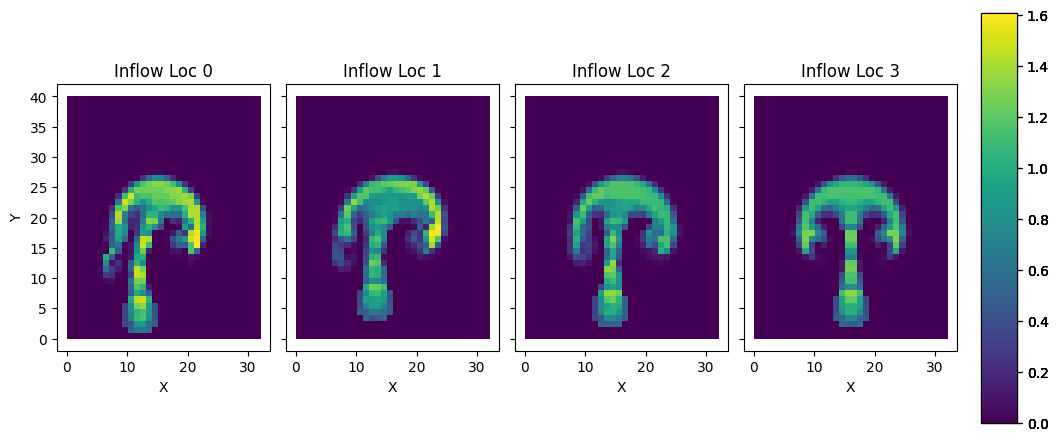

In [5]:
TEST_SMOKE = SMOKE_INIT
TEST_VELOCITY = VELOCITY_INIT

for _ in range(20):
    TEST_SMOKE, TEST_VELOCITY = step(in_smoke=TEST_SMOKE, in_velocity=TEST_VELOCITY, in_inflow=INFLOW, in_dt=1)

plot(TEST_SMOKE)